In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Анализ и очистка датасета

In [2]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
100% 1.08G/1.08G [00:16<00:00, 95.6MB/s]
100% 1.08G/1.08G [00:16<00:00, 68.9MB/s]


In [3]:
with zipfile.ZipFile('the-simpsons-characters-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
#Вместо того, чтобы доверять файлу number_pic_char.csv — изучим фактическое содержимое папок
dataset_folder = "simpsons_dataset"  # Путь к основной папке с данными
kaggle_test_folder = "kaggle_simpson_testset/kaggle_simpson_testset"  # Путь к папке с тестовым набором данных

# Словарь для хранения количества изображений в каждой папке персонажей
dataset_counts = {}
kaggle_test_counts = {}

In [5]:
# Подсчет количества изображений в каждой папке персонажей в 'simpsons_dataset'
for character in os.listdir(dataset_folder):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.isdir(character_folder_path):
        image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        dataset_counts[character] = image_count

In [6]:
# Подсчет количества изображений в 'kaggle_simpsons_testset' с учетом шаблона именования файлов
for file_name in os.listdir(kaggle_test_folder):
    if os.path.isfile(os.path.join(kaggle_test_folder, file_name)):
        # Извлечение имени персонажа из имени файла, удаляя часть после последнего подчеркивания и номера
        character = '_'.join(file_name.split('_')[:-1])
        if character in kaggle_test_counts:
            kaggle_test_counts[character] += 1
        else:
            kaggle_test_counts[character] = 1

In [7]:
# Создание DataFrame для удобного отображения результатов
dataset_df = pd.DataFrame(list(dataset_counts.items()), columns=['Класс', 's_d'])
kaggle_test_df = pd.DataFrame(list(kaggle_test_counts.items()), columns=['Класс', 'k_s_t'])

In [8]:
# Объединяем информацию из двух папок, чтобы сравнить
combined_df = pd.merge(dataset_df, kaggle_test_df, on='Класс', how='outer').fillna(0)
combined_df.rename(columns={'k_s_t': 'k_s_t'}, inplace=True)
combined_df['s_d'] = combined_df['s_d'].astype(int)
combined_df['k_s_t'] = combined_df['k_s_t'].astype(int)

# Выводим информацию о количестве изображений в каждой папке
print(combined_df[['Класс', 's_d', 'k_s_t']].sort_values(by=['s_d', 'k_s_t'], ascending=False))

                       Класс   s_d  k_s_t
15             homer_simpson  2246     50
28              ned_flanders  1454     49
27               moe_szyslak  1452     50
20              lisa_simpson  1354     50
4               bart_simpson  1342     50
22             marge_simpson  1291     50
17          krusty_the_clown  1206     50
32         principal_skinner  1194     50
6   charles_montgomery_burns  1193     48
25       milhouse_van_houten  1079     49
7               chief_wiggum   986     50
0     abraham_grampa_simpson   913     48
37              sideshow_bob   877     47
2     apu_nahasapeemapetilon   623     50
16             kent_brockman   498     50
9             comic_book_guy   469     49
11            edna_krabappel   457     50
29              nelson_muntz   358     50
18             lenny_leonard   310     50
24              mayor_quimby   246     50
42           waylon_smithers   181      0
21            maggie_simpson   128      0
14      groundskeeper_willie   121

Видим, что среди персонажей затесалась лишняя папка simpsons_dataset. Важно сопоставить ее содержимое с основным массивом — вдруг там новые данные.

Также можем сравнить содержимое основной и тестовой папок —  видимо название соотвествует содержимому и в тесте лежат тестовые данные. Поскольку мы будем выделять тестовую часть выборки позже — считаю данные из теста можно объединить с основными.

In [9]:
# Проверка вложенной папки 'simpsons_dataset/simpsons_dataset'
nested_dataset_folder = os.path.join(dataset_folder, 'simpsons_dataset')
nested_dataset_counts = {}

if os.path.exists(nested_dataset_folder) and os.path.isdir(nested_dataset_folder):
    for character in os.listdir(nested_dataset_folder):
        character_folder_path = os.path.join(nested_dataset_folder, character)
        if os.path.isdir(character_folder_path):
            image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
            nested_dataset_counts[character] = image_count

In [10]:
# Сравнение изображений из основной и вложенной папок
from hashlib import md5

def get_file_checksum(file_path):
    with open(file_path, 'rb') as f:
        return md5(f.read()).hexdigest()

matching_files = []
different_files = []

In [11]:
for character in dataset_counts.keys():
    original_folder = os.path.join(dataset_folder, character)
    nested_folder = os.path.join(nested_dataset_folder, character)

    if os.path.exists(nested_folder):
        original_files = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]
        nested_files = [f for f in os.listdir(nested_folder) if os.path.isfile(os.path.join(nested_folder, f))]

        for file_name in original_files:
            original_file_path = os.path.join(original_folder, file_name)
            nested_file_path = os.path.join(nested_folder, file_name)

            if os.path.exists(nested_file_path):
                original_checksum = get_file_checksum(original_file_path)
                nested_checksum = get_file_checksum(nested_file_path)

                if original_checksum == nested_checksum:
                    matching_files.append((original_file_path, nested_file_path))
                else:
                    different_files.append((original_file_path, nested_file_path))

print(f"Совпадающие файлы: {len(matching_files)}")
print(f"Различные файлы: {len(different_files)}")


Совпадающие файлы: 20933
Различные файлы: 0


По результатам проверки очевидно, что это дубликат. Значит его можно спокойно удалить.

In [12]:
# Перемещение изображений из 'kaggle_simpsons_testset' в соответствующие папки в 'simpsons_dataset'
missing_characters = []

for file_name in os.listdir(kaggle_test_folder):
    if os.path.isfile(os.path.join(kaggle_test_folder, file_name)):
        # Извлечение имени персонажа из имени файла, удаляя часть после последнего подчеркивания и номера
        character = '_'.join(file_name.split('_')[:-1])
        character_folder_path = os.path.join(dataset_folder, character)

        # Проверяем, существует ли папка для персонажа в основном датасете
        if os.path.exists(character_folder_path):
            # Перемещаем файл в соответствующую папку
            original_file_path = os.path.join(kaggle_test_folder, file_name)
            new_file_path = os.path.join(character_folder_path, file_name)
            os.rename(original_file_path, new_file_path)
        else:
            # Добавляем персонажа в список отсутствующих
            missing_characters.append(character)

# Вывод списка персонажей, для которых не нашлось соответствующих папок
print("Персонажи, для которых не нашлось соответствующих папок в основном датасете:")
print(set(missing_characters))

Персонажи, для которых не нашлось соответствующих папок в основном датасете:
set()


In [13]:
# Подсчет количества изображений в каждой папке после перемещения данных из 'kaggle_simpsons_testset'
dataset_counts_after_merge = {}
for character in os.listdir(dataset_folder):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.isdir(character_folder_path):
        image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        dataset_counts_after_merge[character] = image_count

# Создание DataFrame для удобного отображения результатов после объединения
dataset_df_after_merge = pd.DataFrame(list(dataset_counts_after_merge.items()), columns=['Класс', 's_d'])

# Выводим информацию о количестве изображений в каждой папке после объединения
print("Количество изображений в каждой папке после объединения с тестовой выборкой:")
print(dataset_df_after_merge.sort_values(by=['s_d'], ascending=False))

Количество изображений в каждой папке после объединения с тестовой выборкой:
                       Класс   s_d
35             homer_simpson  2296
26              ned_flanders  1503
30               moe_szyslak  1502
1               lisa_simpson  1404
20              bart_simpson  1392
4              marge_simpson  1341
40          krusty_the_clown  1256
17         principal_skinner  1244
27  charles_montgomery_burns  1241
41       milhouse_van_houten  1128
0               chief_wiggum  1036
29    abraham_grampa_simpson   961
37              sideshow_bob   924
19    apu_nahasapeemapetilon   673
21             kent_brockman   548
2             comic_book_guy   518
38            edna_krabappel   507
39              nelson_muntz   408
16             lenny_leonard   360
33              mayor_quimby   296
36           waylon_smithers   181
11            maggie_simpson   128
9       groundskeeper_willie   121
24             barney_gumble   106
3              selma_bouvier   103
12           

In [14]:
# Удаление вложенной папки после проверки
import shutil
shutil.rmtree('/content/simpsons_dataset/simpsons_dataset')
print("Папка '/content/simpsons_dataset/simpsons_dataset' удалена.")

Папка '/content/simpsons_dataset/simpsons_dataset' удалена.


In [15]:
df = pd.DataFrame(list(dataset_counts_after_merge.items()), columns=['name', 'count'])

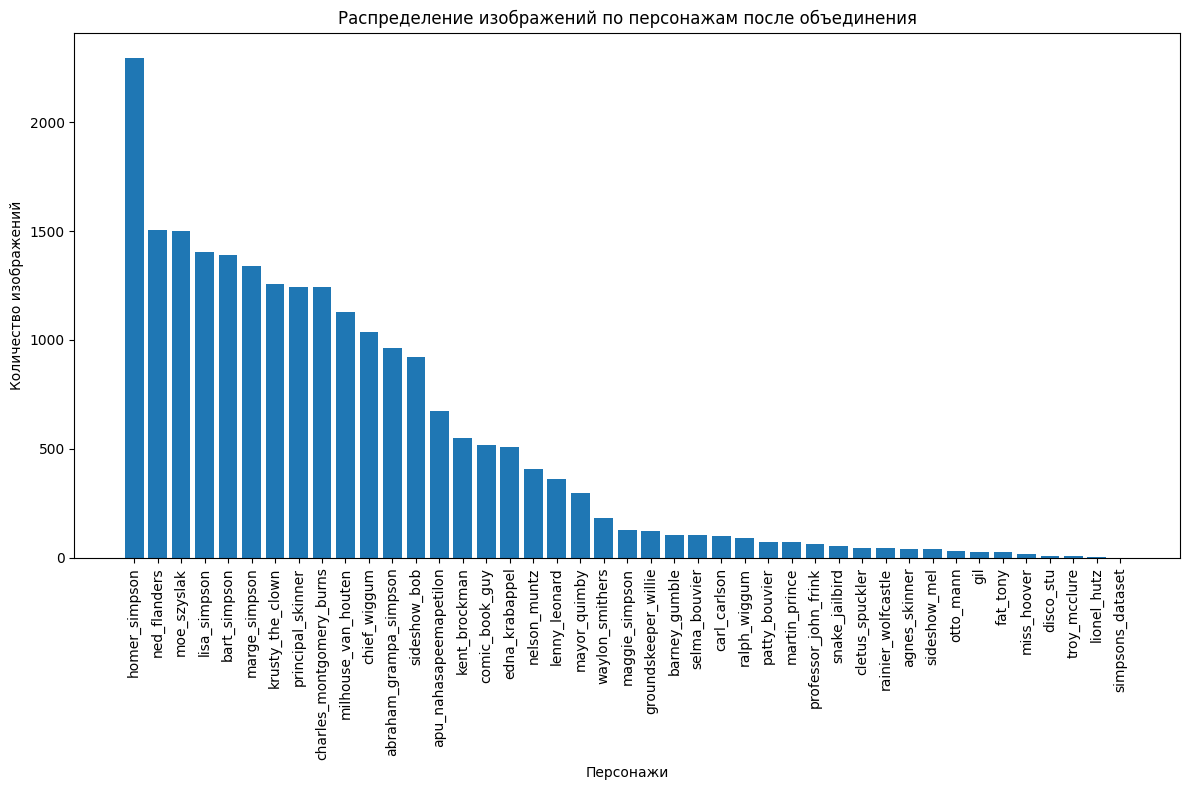

In [16]:
# Настройка графика
plt.figure(figsize=(12, 8))
df_sorted = df.sort_values(by=['count'], ascending=False)
plt.bar(df_sorted['name'], df_sorted['count'])
plt.xlabel('Персонажи')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по персонажам после объединения')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
#Видимо, что для некоторых персонажей информации очень мало. Посмотрим, насколько мало
min_values = df.nsmallest(20, 'count')
print(min_values)

                    name  count
34      simpsons_dataset      0
25           lionel_hutz      3
23          troy_mcclure      8
31             disco_stu      8
6            miss_hoover     17
13                   gil     27
42              fat_tony     27
22             otto_mann     32
5           sideshow_mel     40
32         agnes_skinner     42
7     rainier_wolfcastle     45
18       cletus_spuckler     47
14        snake_jailbird     55
28  professor_john_frink     65
15         martin_prince     71
10         patty_bouvier     72
8           ralph_wiggum     89
12          carl_carlson     98
3          selma_bouvier    103
24         barney_gumble    106


Google Cloud рекомендует для CNN классификатора минимум 50–100 изображений на класс.
50 - если изображения внутри класса похожи. Важно не потерять разнообразие классов, поэтому будем проводить аугментацию для всех персонажей.

In [18]:
# Среднее кол-во изображений в классе имеет смысл считать уже на подвыборке
mean_count = df['count'].mean()
print(mean_count)

509.83720930232556


In [19]:
# Из распределения мы знаем, что у нас значительный дисбаланс классов
# Воспользуемся правилом х delta чтобы определить слишком малые и большие классы

delta = 5 #во сколько раз отличие от среднего

# Разбиваем классы на группы
# Слишком много данных (более чем в delta раз превышает среднее)
too_many_data = df[df['count'] > delta * mean_count]['name']

# Оптимальное количество данных (близко к среднему, в пределах delta)
optimal_data = df[(df['count'] <= delta * mean_count) & (df['count'] >= mean_count / delta)]['name']

# Слишком мало данных (более чем в delta раз меньше среднего)
too_few_data = df[df['count'] < mean_count / delta]['name']


# Преобразуем имена в нужный формат (чтобы совпадало с тем, что в папках)
formatted_too_many_data = too_many_data.str.lower().str.replace(' ', '_')
formatted_optimal_data = optimal_data.str.lower().str.replace(' ', '_')
formatted_too_few_data = too_few_data.str.lower().str.replace(' ', '_')

# Результаты
print("Классы с слишком большим количеством данных:", formatted_too_many_data.tolist())
print("Классы с оптимальным количеством данных:", formatted_optimal_data.tolist())
print("Классы с слишком малым количеством данных:", formatted_too_few_data.tolist())

Классы с слишком большим количеством данных: []
Классы с оптимальным количеством данных: ['chief_wiggum', 'lisa_simpson', 'comic_book_guy', 'selma_bouvier', 'marge_simpson', 'groundskeeper_willie', 'maggie_simpson', 'lenny_leonard', 'principal_skinner', 'apu_nahasapeemapetilon', 'bart_simpson', 'kent_brockman', 'barney_gumble', 'ned_flanders', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'moe_szyslak', 'mayor_quimby', 'homer_simpson', 'waylon_smithers', 'sideshow_bob', 'edna_krabappel', 'nelson_muntz', 'krusty_the_clown', 'milhouse_van_houten']
Классы с слишком малым количеством данных: ['sideshow_mel', 'miss_hoover', 'rainier_wolfcastle', 'ralph_wiggum', 'patty_bouvier', 'carl_carlson', 'gil', 'snake_jailbird', 'martin_prince', 'cletus_spuckler', 'otto_mann', 'troy_mcclure', 'lionel_hutz', 'professor_john_frink', 'disco_stu', 'agnes_skinner', 'simpsons_dataset', 'fat_tony']


In [20]:
dataset_folder = 'simpsons_dataset'

In [70]:
# Разделение на images и labels
images = []
labels = []

# Перебираем папки и собираем изображения и метки
for character in pd.concat([formatted_optimal_data, formatted_too_few_data]):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.exists(character_folder_path):
        for file_name in os.listdir(character_folder_path):
            file_path = os.path.join(character_folder_path, file_name)
            if os.path.isfile(file_path):
                images.append(file_path)
                labels.append(character)

# Проверяем результаты разделения на images и labels
print(f'Количество изображений: {len(images)}')
print(f'Количество меток: {len(labels)}')
print(f'Пример изображения: {images[0] if images else "Нет изображений"}')
print(f'Пример метки: {labels[0] if labels else "Нет меток"}')

Количество изображений: 21923
Количество меток: 21923
Пример изображения: simpsons_dataset/chief_wiggum/pic_0182.jpg
Пример метки: chief_wiggum


# 3. Аугментация данных
Генерируем доп изображения в малые классы, чтобы скорректировать дисбаланс классов.

Что подойдет:
- Небольшое изменение масштаба, сдивиги, поворот


Что не подойдет:
- Ротация на 90 градусов и более
- Сильная обрезка изображений, фрагментирование портретов
- Изменение цвета для мультка со узнаваемой цветовой схемой это может быть фатально
- Сильный шум или размытие не характерны для скриншотов из мультика — такие методы скорее подойдут для фото из реальной жизни

Аугментацию можно проводить как отдельно, так и на лету (онлайн), прямо во время обучения модели, с использованием тех же библиотек tensorflow или аналогов.

Оставлю пример кода как для отедльной, так и для онлайновой аугментации.

In [23]:
# Настройка параметров генерации изображений
augmented_images = []
augmented_labels = []

datagen = ImageDataGenerator(
    rescale=1./255, #чтобы привести значение пикселя к от 0 до 1 (так лучше для модели)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation_counts = {}  # Для отслеживания количества сгенерированных изображений для каждого класса
augmented_image_paths = []  # Для хранения путей к сгенерированным изображениям

augmented_dataset_folder = "augmented_dataset"  # Папка для сохранения сгенерированных изображений
os.makedirs(augmented_dataset_folder, exist_ok=True)

In [24]:
# Аугментация для классов с недостаточным количеством данных
for character in formatted_too_few_data:
    character_folder_path = os.path.join(dataset_folder, character)
    augmented_character_folder_path = os.path.join(augmented_dataset_folder, character)
    os.makedirs(augmented_character_folder_path, exist_ok=True)

    if os.path.exists(character_folder_path):
        current_count = len(os.listdir(character_folder_path))
        target_count = int(mean_count)  # Целевое количество изображений для каждого класса = среднее
        images_needed = target_count - current_count
        augmentation_counts[character] = 0

        if images_needed > 0:
            for file_name in os.listdir(character_folder_path):
                file_path = os.path.join(character_folder_path, file_name)
                if os.path.isfile(file_path):
                    # Проверка существования файла и корректности пути
                    if not os.path.exists(file_path):
                        print(f"Ошибка: файл {file_path} не существует.")
                        continue
                    try:
                        # Чтение изображения
                        img = cv2.imread(file_path)
                        if img is None:
                            print(f"Ошибка: не удалось прочитать изображение {file_path}.")
                            continue
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (64, 64))  # Приводим к единому размеру
                         # Применение аугментации
                        img = img.reshape((1,) + img.shape)  # Преобразуем для генератора
                        i = 0
                        for batch in datagen.flow(img, batch_size=1):
                            augmented_img = (batch[0] * 255).astype(np.uint8)  # Преобразуем обратно в изображение
                            save_path = os.path.join(augmented_character_folder_path, f"augmented_{file_name.split('.')[0]}_{i}.jpg")
                            cv2.imwrite(save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))
                            augmented_images.append(save_path)
                            augmented_labels.append(character)
                            augmentation_counts[character] += 1
                            augmented_image_paths.append(save_path)
                            i += 1
                            if i >= images_needed:  # Ограничение на количество сгенерированных изображений для достижения целевого количества
                                break
                        if augmentation_counts[character] >= images_needed:
                            break
                    except Exception as e:
                        print(f"Ошибка при обработке файла {file_path}: {e}")


In [25]:
# Таблица с количеством сгенерированных изображений для каждого класса
augmentation_df = pd.DataFrame(list(augmentation_counts.items()), columns=['Класс', 'Количество сгенерированных изображений'])
print(augmentation_df)

                   Класс  Количество сгенерированных изображений
0           ralph_wiggum                                     420
1               fat_tony                                     482
2         snake_jailbird                                     454
3           carl_carlson                                     411
4                    gil                                     482
5              disco_stu                                     501
6            miss_hoover                                     492
7            lionel_hutz                                     506
8          patty_bouvier                                     437
9   professor_john_frink                                     444
10         agnes_skinner                                     467
11    rainier_wolfcastle                                     464
12          troy_mcclure                                     501
13             otto_mann                                     477
14          sideshow_mel 

In [26]:
# Теперь можно объединить оригинальные и аугментированные изображения и метки
images.extend(augmented_images)
labels.extend(augmented_labels)

print(f'Общее количество изображений после аугментации: {len(images)}')
print(f'Общее количество меток после аугментации: {len(labels)}')

Общее количество изображений после аугментации: 29830
Общее количество меток после аугментации: 29830


In [28]:
# Подготовка данных для модели
filtered_X_train = []
filtered_y_train = []
for img_path, label in zip(X_train, y_train):
    img = cv2.imread(str(img_path))
    if img is not None:
        img = cv2.resize(img, (64, 64)) #поискать другой трансформер для пред процессинга
        filtered_X_train.append(img)
        filtered_y_train.append(label)
X_train_images = np.array(filtered_X_train) / 255.0  # Нормализация

filtered_X_test = []
filtered_y_test = []
for img_path, label in zip(X_test, y_test):
    img = cv2.imread(str(img_path))
    if img is not None:
        img = cv2.resize(img, (64, 64))
        filtered_X_test.append(img)
        filtered_y_test.append(label)
X_test_images = np.array(filtered_X_test) / 255.0  # Нормализация


NameError: name 'X_train' is not defined

# 4. Создание модели

In [55]:
# Преобразование меток в числовой вид перед разделением
label_mapping = {label: idx for idx, label in enumerate(set(labels))}
labels = [label_mapping[label] for label in labels]

unique_labels = set(labels)
print("Уникальные метки:", unique_labels)

Уникальные метки: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41}


In [73]:
# Разделение на тренировочный и тестовый наборы
data = pd.DataFrame({'image': images, 'label': labels})
print(data.head())
print(data['label'].value_counts())
sum_labels = data['label'].value_counts().sum()

print(f"Сумма меток: {sum_labels}")

                                        image         label
0  simpsons_dataset/chief_wiggum/pic_0182.jpg  chief_wiggum
1  simpsons_dataset/chief_wiggum/pic_0769.jpg  chief_wiggum
2  simpsons_dataset/chief_wiggum/pic_0833.jpg  chief_wiggum
3  simpsons_dataset/chief_wiggum/pic_0709.jpg  chief_wiggum
4  simpsons_dataset/chief_wiggum/pic_0608.jpg  chief_wiggum
label
homer_simpson               2296
ned_flanders                1503
moe_szyslak                 1502
lisa_simpson                1404
bart_simpson                1392
marge_simpson               1341
krusty_the_clown            1256
principal_skinner           1244
charles_montgomery_burns    1241
milhouse_van_houten         1128
chief_wiggum                1036
abraham_grampa_simpson       961
sideshow_bob                 924
apu_nahasapeemapetilon       673
kent_brockman                548
comic_book_guy               518
edna_krabappel               507
nelson_muntz                 408
lenny_leonard                360
mayor_q

In [78]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data['image'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)

In [81]:
# Вывод статистики для y_train
print("Статистика для y_train:")
print(f"Количество элементов: {len(y_train)}")
print(f"Уникальные метки: {set(y_train)}")
print(f"Количество уникальных меток: {len(set(y_train))}")

# Подсчет количества каждой уникальной метки
label_counts = pd.Series(y_train).value_counts()
print("\nКоличество каждой уникальной метки:")
print(label_counts)

# Если нужно вывести статистику для y_test
print("\nСтатистика для y_test:")
print(f"Количество элементов: {len(y_test)}")
print(f"Уникальные метки: {set(y_test)}")
print(f"Количество уникальных меток: {len(set(y_test))}")

Статистика для y_train:
Количество элементов: 17538
Уникальные метки: {'groundskeeper_willie', 'martin_prince', 'professor_john_frink', 'troy_mcclure', 'otto_mann', 'marge_simpson', 'maggie_simpson', 'principal_skinner', 'patty_bouvier', 'apu_nahasapeemapetilon', 'miss_hoover', 'nelson_muntz', 'chief_wiggum', 'charles_montgomery_burns', 'carl_carlson', 'cletus_spuckler', 'lionel_hutz', 'lisa_simpson', 'moe_szyslak', 'gil', 'edna_krabappel', 'homer_simpson', 'ralph_wiggum', 'rainier_wolfcastle', 'bart_simpson', 'fat_tony', 'ned_flanders', 'waylon_smithers', 'lenny_leonard', 'disco_stu', 'milhouse_van_houten', 'krusty_the_clown', 'snake_jailbird', 'sideshow_bob', 'abraham_grampa_simpson', 'selma_bouvier', 'kent_brockman', 'agnes_skinner', 'mayor_quimby', 'barney_gumble', 'comic_book_guy', 'sideshow_mel'}
Количество уникальных меток: 42

Количество каждой уникальной метки:
homer_simpson               1837
ned_flanders                1202
moe_szyslak                 1201
lisa_simpson      

In [87]:
# Преобразование меток в числовой формат
label_to_int = {label: idx for idx, label in enumerate(set(y_train))}
y_train_encoded = [label_to_int[label] for label in y_train]
y_test_encoded = [label_to_int[label] for label in y_test]

# One-hot encoding с использованием to_categorical
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Проверка результата
print("Преобразованные метки y_train (one-hot):")
print(y_train_one_hot[:5])  # Показать первые 5 преобразованных меток
print("Количество уникальных меток:", len(label_to_int))  # Количество классов

Преобразованные метки y_train (one-hot):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Количество уникальных меток: 42


In [88]:
# Настройка ImageDataGenerator для онлайн-аугментации данных
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [89]:
# Создание генератора изображений
datagen = ImageDataGenerator(rescale=1./255)  # Нормализация изображений

# Создание генераторов для тренировочного набора
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': list(y_train_one_hot)}),  # Используем закодированные метки
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'  # Убедитесь, что class_mode установлен на 'categorical'
)

# Создание генераторов для тестового набора (если необходимо)
test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': list(y_test_one_hot)}),  # Используем закодированные метки
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

TypeError: If class_mode="categorical", y_col="class" column values must be type string, list or tuple.

Пример меток y_train перед преобразованием: ['lenny_leonard', 'homer_simpson', 'bart_simpson', 'lisa_simpson', 'lenny_leonard', 'principal_skinner', 'sideshow_bob', 'apu_nahasapeemapetilon', 'chief_wiggum', 'moe_szyslak']
Пример меток y_test перед преобразованием: ['krusty_the_clown', 'nelson_muntz', 'abraham_grampa_simpson', 'comic_book_guy', 'homer_simpson', 'moe_szyslak', 'krusty_the_clown', 'abraham_grampa_simpson', 'sideshow_bob', 'abraham_grampa_simpson']


ValueError: invalid literal for int() with base 10: 'lenny_leonard'

In [47]:
# Преобразование меток train и test в строковый формат перед использованием в генераторах
y_train_labels = [str(label) for label in np.argmax(y_train, axis=1)]
y_test_labels = [str(label) for label in np.argmax(y_test, axis=1)]

In [67]:
# Обновление данных в генераторах

# Проверка наличия всех файлов в тестовом наборе
missing_files_test = [path for path in dataframe_test['filename'] if not os.path.exists(path)]
print(f"Количество отсутствующих файлов в тестовом наборе: {len(missing_files_test)}")
if missing_files_test:
    print("Отсутствующие файлы в тестовом наборе:")
    print(missing_files_test[:10])  # Печать первых 10 отсутствующих файлов

# Проверка количества данных в генераторах
train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Добавляем перемешивание данных для улучшения обучения
)

Количество отсутствующих файлов в тестовом наборе: 0
Found 17538 validated image filenames belonging to 42 classes.


In [69]:
# Проверка распределения классов в train_generator
print("Количество изображений в train_generator после генерации:", train_generator.samples)
print("Классы train_generator:", train_generator.class_indices)

# Обновление label_mapping из классов генератора, чтобы избежать несоответствий
label_mapping = train_generator.class_indices

Количество изображений в train_generator после генерации: 17538
Классы train_generator: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '5': 37, '6': 38, '7': 39, '8': 40, '9': 41}


In [63]:
# Тестовый генератор
test_generator = datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Тестовые данные не должны быть перемешаны для корректной оценки
)

Found 4385 validated image filenames belonging to 42 classes.


In [64]:
# Проверка распределения классов в test_generator
print("Количество изображений в test_generator после генерации:", test_generator.samples)
print(f"Количество изображений в test_generator: {test_generator.samples}")
dataframe_train = pd.DataFrame({'filename': X_train, 'class': y_train_labels})
dataframe_test = pd.DataFrame({'filename': X_test, 'class': y_test_labels})
train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Количество изображений в test_generator после генерации: 4385
Количество изображений в test_generator: 4385
Found 17538 validated image filenames belonging to 42 classes.


In [65]:
# Обновление тестового генератора
test_generator = datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 4385 validated image filenames belonging to 42 classes.


In [50]:
# Создание модели
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_mapping), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Softmax — ф-я для преобразования вектора реальных чисел в вероятностное распределение. Подходит для задач многоклассовой классификации входных данных.

Преобразует каждый элемент входного вектора в значение от 0 до 1, причем сумма всех выходных значений равна 1. Это позволяет интерпретировать выходные данные как вероятности принадлежности к каждому из классов.

# 5. Компиляция и обучение модели

In [51]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# когда выбрала в качестве метрики ф1 — модель успешно обучилась до val_f1: 0.9061, val_loss: 2.3674
# при этом в стате модели все было нулевое, поэтому вернулась к классике и акураси

Категориальная кросс-энтропия — это функция потерь, используемая в задачах многоклассовой классификации, где модель должна предсказать вероятность принадлежности примера к одной из нескольких категорий.

Измеряет разницу между истинным распределением вероятностей (обычно закодированным в формате one-hot) и предсказанным распределением вероятностей, полученным от модели (обычно через softmax).

In [52]:
# Обучение модели с использованием онлайн-аугментации
model.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 175s 316ms/step - accuracy: 0.0763 - loss: 3.2894 - val_accuracy: 0.1047 - val_loss: 3.1102
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 173s 314ms/step - accuracy: 0.1063 - loss: 3.1098 - val_accuracy: 0.1558 - val_loss: 2.9605
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 201s 313ms/step - accuracy: 0.1480 - loss: 2.9933 - val_accuracy: 0.2062 - val_loss: 2.8342
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 174s 315ms/step - accuracy: 0.1888 - loss: 2.8869 - val_accuracy: 0.2424 - val_loss: 2.7185
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 173s 314ms/step - accuracy: 0.2131 - loss: 2.7838 - val_accuracy: 0.2878 - val_loss: 2.5955
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 201s 313ms/step - accuracy: 0.2277 - loss: 2.7083 - val_accuracy: 0.2974 - val_loss: 2.5246
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 204s 316ms/step - accuracy: 0.2513 - loss: 2.6602 - val_accuracy: 0.3318 - val_loss: 2.4566
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 172s 312ms/step - accuracy: 0.2703 - loss: 2.60

In [53]:
# Оценка модели и метрики
y_pred = model.predict(test_generator)

# Вывод отчета по метрикам классификации
report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_mapping.keys()))
print(report)

138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step
                          precision    recall  f1-score   support

    groundskeeper_willie       0.00      0.00      0.00        24
           martin_prince       0.00      0.00      0.00        14
    professor_john_frink       0.00      0.00      0.00        13
            troy_mcclure       0.00      0.00      0.00         2
               otto_mann       0.00      0.17      0.01         6
           marge_simpson       0.09      0.04      0.05       268
          maggie_simpson       0.00      0.00      0.00        26
       principal_skinner       0.00      0.00      0.00       249
           patty_bouvier       0.00      0.00      0.00        14
  apu_nahasapeemapetilon       0.06      0.07      0.06       135
             miss_hoover       0.00      0.00      0.00         3
            nelson_muntz       0.00      0.00      0.00        82
            chief_wiggum       0.00      0.00      0.00       207
charles_montgomery_burns       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision — показывает, насколько точно модель предсказывает положительные классы. Если модель классифицирует кадры с Гомером Симпсоном, и она предсказывает 10 кадров как "Гомер", но только 8 из них действительно являются Гомером, то precision будет равен 80%.


Recall — это метрика, которая показывает, насколько хорошо модель находит все истинные положительные примеры. Если в наборе данных есть 15 кадров с Гомером, а модель правильно классифицировала только 8 из них, то recall будет равен 53% (8 истинных положительных из 15 фактических положительных).


F1-score — это гармоническое среднее между precision и recall. Он позволяет объединить обе метрики в одну и дает более полное представление о производительности модели. Использование F1-score полезно в ситуациях с несбалансированными классами, когда важно учитывать как точность, так и полноту.

Support — это просто количество истинных экземпляров для каждого класса в тестовом наборе данных. Показывает, сколько тестовых примеров есть в каждом классе и помогает понять распределение классов в данных.

Лосс (или функция потерь) — это мера, которая показывает, насколько хорошо или плохо модель предсказывает результаты по сравнению с фактическими значениями. Она используется для оценки качества модели во время обучения и оптимизации. Лосс помогает алгоритму понять, насколько далеко его предсказания от истинных значений, и на основании этого корректировать свои параметры. Используется в процессе обучения, тогда как метрики — оценивают его итог.

In [37]:
# Построение графика loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

In [39]:
print("Test generator class indices:", test_generator.class_indices)
print("Label mapping:", label_mapping)


Test generator class indices: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '5': 37, '6': 38, '7': 39, '8': 40, '9': 41}
Label mapping: {'groundskeeper_willie': 0, 'martin_prince': 1, 'professor_john_frink': 2, 'troy_mcclure': 3, 'otto_mann': 4, 'marge_simpson': 5, 'maggie_simpson': 6, 'principal_skinner': 7, 'patty_bouvier': 8, 'apu_nahasapeemapetilon': 9, 'miss_hoover': 10, 'nelson_muntz': 11, 'chief_wiggum': 12, 'charles_montgomery_burns': 13, 'carl_carlson': 14, 'cletus_spuckler': 15, 'lionel_hutz': 16, 'lisa_simpson': 17, 'moe_szyslak': 18, 'gil': 19, 'edna_krabappel': 20, 'homer_simpson': 21, 'ralph_wiggum': 22, 'rainier_wolfcastle': 23, 'bart_simpson': 24, 'fat_tony': 25, 'n